# Online STL
- Trend Filter
- Seasonal Filter

<b>reference</b><br/>
A. Mishra, R. Sriharsha, and S. Zhong, “OnlineSTL: Scaling Time Series Decomposition by 100x,” arXiv:2107.09110 [cs], Feb. 2022, Accessed: May 11, 2022. [Online]. Available: http://arxiv.org/abs/2107.09110

In [2]:
import numpy as np
import pandas as pd

<AxesSubplot:>

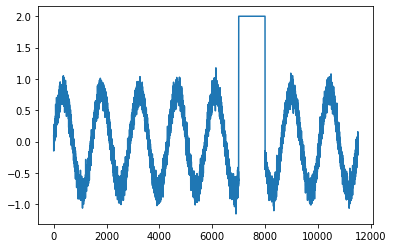

In [3]:
# 生成测试数据
x=np.linspace(0,8*2*np.pi,8*1440)
y=0.8 * np.sin(x) + 0.10 * np.random.randn(8 * 1440)
series = pd.Series(y)
# 注入异常
for i in range(7000, 8000):
    y[i] = 2.0
series.plot.line()

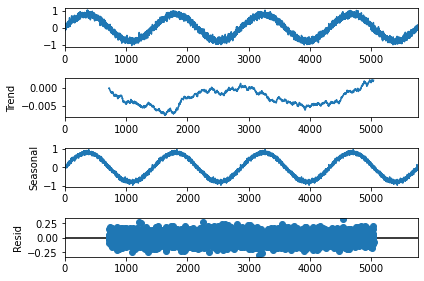

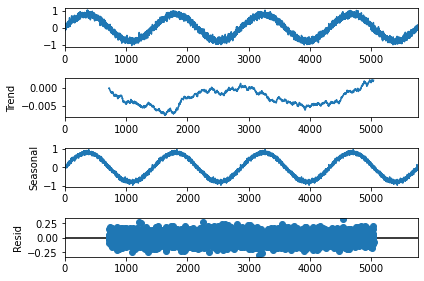

In [7]:
# * 探索代码
from statsmodels.tsa.seasonal import seasonal_decompose
result=seasonal_decompose(series[0:4*1440], model='additive', period=1440)
result.plot()

<AxesSubplot:>

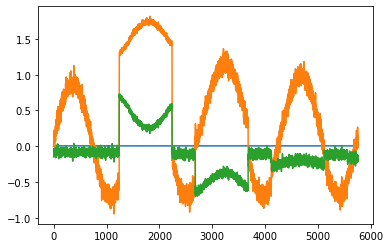

In [8]:
# Functional Test
stl = OnlineSTL(series[0:4*1440], 1440)
T = []
S = []
R = []
for i in range(4 * 1440, 8 * 1440):
    Ti, Si, Ri = stl.update(series[i])
    T.append(Ti)
    S.append(Si)
    R.append(Ri)
pd.Series(T).plot.line()
pd.Series(S).plot.line()
pd.Series(R).plot.line()

<AxesSubplot:>

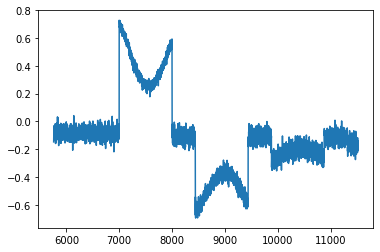

In [9]:
# recon error distribution
(series[4*1440:8*1440] - T - S).plot.line()

STL生成的重构误差中，存在拖尾现象

<AxesSubplot:>

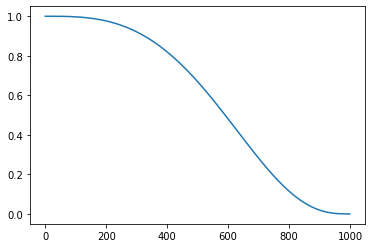

In [19]:
# Unit Test Apple
def tri_cube(u):
    if 0 <= u < 1:
        return ( 1 - u ** 3 ) ** 3
    else:
        return 0
pd.Series(np.linspace(0, 1, 1000)).apply(lambda x: tri_cube(x)).plot.line()

In [67]:
# Unit Test Bear
m = 1
asym_filter_4m = np.zeros((4 * m))
for j in range(0, 4 * m):
    asym_filter_4m[-j-1] = tri_cube(j / 4 / m)
asym_filter_4m

array([0.19322586, 0.66992188, 0.95385361, 1.        ])

In [23]:
# Unit Test Candy
m = 4
asym_filter_m = np.zeros((1, m))
for j in range(0, m):
    asym_filter_m[:, -j-1] = tri_cube(j / m)
asym_filter_m

array([[0.19322586, 0.66992188, 0.95385361, 1.        ]])

In [24]:
# Unit Test Donky
def update_array(array, update):
    updated = np.roll(array, -1)
    updated[-1] = update
    return updated
update_array([1, 2, 3, 4, 5], 6)

array([2, 3, 4, 5, 6])

In [27]:
# Unit Test Egg
def apply_trend_filter(filter, signal):
    return np.dot(filter, signal) / np.linalg.norm(x=filter, ord=1)
apply_trend_filter([0.25, 0.5, 0.25], [2, 4, 6])

4.0

In [44]:
# Unit Test Fermy
m = 1440
A = series[0:4*1440]
result=seasonal_decompose(A, model='additive', period=m)
K = np.array(result.seasonal)
S = T = np.array(K[-m:])
D = (result.trend + result.resid)[-m:]
print(A.shape)
print(K.shape)
print(S.shape)
print(T.shape)
print(D.shape)
S[0]

(5760,)
(5760,)
(1440,)
(1440,)
(1440,)


-0.05688434629533788

# Code Repo

In [5]:
class OnlineSTL:
    '''
        df_train: 1D Series, shape=(1,4*m)
        m       ：period
    '''
    def __init__(self, df_train, m):
        self.m = m
        # Initialize
        # A.shape=(1, 4m)
        self.A = np.array(df_train).copy()
        result=seasonal_decompose(self.A, model='additive', period=m)
        self.K = np.array(result.seasonal).copy()
        self.S = np.array(self.K[-m:]).copy()
        self.T = np.array(self.K[-m:]).copy()
        self.D = np.array((df_train - result.seasonal)[-m:]).copy()
        self.i = 4 * m

        self.asym_filter_4m = self.async_filter(4*m)
        self.asym_filter_m  = self.async_filter(m)
    
    '''
        Tri cube kernel filter
    '''
    def tri_cube(self, u):
        if 0 <= u < 1:
            return ( 1 - u ** 3 ) ** 3
        else:
            return 0
    
    def async_filter(self, n):
        asym_filter_n = np.zeros((n))
        for j in range(0, n):
            asym_filter_n[-j-1] = self.tri_cube(j / n)
        return asym_filter_n

    '''
        Xi: Recent data point
        i : sequential index
    '''
    def update(self, Xi):
        # Update
        def update_array(array, update):
            updated = np.roll(array, -1)
            updated[-1] = update
            return updated
        update_array(self.A, Xi)
        b = Xi
        def apply_trend_filter(filter, signal):
            return np.dot(filter, signal) / np.linalg.norm(x=filter, ord=1)
        t1= apply_trend_filter(self.asym_filter_4m, self.A)
        d1=b - t1
        self.i = self.i + 1
        r = (self.i-1) % self.m
        gamma = 0.7
        self.S[r] = gamma * d1 + (1-gamma) * self.S[r]
        update_array(self.K, self.S[r])
        t4= apply_trend_filter(self.asym_filter_4m, self.K)
        d5= b - t1 - t4
        self.T[r] = gamma * d5 + (1-gamma) * self.T[r]
        b = b - self.T[r]
        update_array(self.D, b)
        Ti=apply_trend_filter(self.asym_filter_m, self.D)
        Si=self.T[r]
        Ri=Xi - Ti - Si
        return Ti, Si, Ri